In [1]:
import numpy as np
from scipy.optimize import leastsq
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from scipy import special
from scipy import interpolate
from scipy.interpolate import UnivariateSpline
import glob
plt.rcParams['figure.figsize'] = [11, 8]


In [2]:
def continuum(wl, fl, fe, threshold):
    fl_out, wl_out, fe_out = trim(wl, fl, 2, np.mean(fl), fe) 
    ctn_func = UnivariateSpline(wl_out, fl_out)
    ctn = ctn_func(wl_out)
    i, fl_prev = 0, fl
    while(len(fl_prev) != len(fl_out) or i > 20):
        fl_prev = fl_out
        fl_out, wl_out, fe_out = trim(wl_out, fl_out, threshold, ctn, fe_out) 
        ctn_func = UnivariateSpline(wl_out, fl_out)
        ctn = ctn_func(wl_out)
        i += 1
    return wl_out, fl_out, fe_out, ctn_func # return out all of the i values to see 

def plot_continuum(wl, wl_out, fl, fl_out, ctn_given, ctn_func, name, t):
    plt.plot(wl, ctn_given, 'b-', label='Given Continuum')
    plt.step(wl, fl, 'g-', lw=2, where='mid', label='Data')
    plt.plot(wl_out, fl_out, 'k-', label='Trimmed Data')
    plt.plot(wl, ctn_func(wl), '-r', label='Fitted Continuum')
    plt.plot([],[],' ', label=('Threshold: ' + str(t)))
    plt.xlabel('Wavelength [A]')
    plt.ylabel('Flux')
    plt.title(name)
    plt.legend()
    plt.show()

def plot_chi_histogram(chi, chi_mean):
    mean = 'Mean: ' + str(chi_mean)
    plt.hist(chi)
    plt.plot([],[],'', label=mean)
    plt.title('Chi Values')
    plt.xlabel('Chi')
    plt.legend()
    plt.show()

def find_chi(wl, fl, fe, ctn):
    lower = np.min(np.where(wl > 1547))
    upper = np.max(np.where(wl < 1552))
    flag = np.invert((wl > 1547) & (wl < 1552))
    chi = Chi(ctn[flag], fl[flag], fe[flag])
    return chi, np.mean(chi)

def trim(wl, fl, threshold, reference, fe):
    flag = fl > reference - threshold*fe
    fl_new = fl[flag]
    wl_new = wl[flag]
    fe_new = fe[flag]
    return fl_new, wl_new, fe_new

def func(x, a, b, c, d):
    return a*x**3 + b*x**2 + c*x + d

def Chi_sq(model, data, error):
    return np.sum((model-data)**2 / error**2)

def Chi(model, data, error):
    return (data - model) / error 

def find_continuum(name):
    threshold = np.arange(1.2, 2, .1)
    t = threshold[0]
    wl_out, fl_out, fe_out, ctn_func = continuum(wl, fl, fe, t)
    chi, chi_mean = find_chi(wl, fl, fe, ctn_func(wl))
    for th in threshold:
        wl_1, fl_1, fe_1, ctn_function = continuum(wl, fl, fe, th)
        chi_1, chi_mean_1 = find_chi(wl, fl, fe, ctn_function(wl))
        if (np.abs(chi_mean_1) < np.abs(chi_mean)):
            wl_out, fl_out, fe_out, ctn_func = wl_1, fl_1, fe_1, ctn_function
            t = th
            chi, chi_mean = chi_1, chi_mean_1
    plot_continuum(wl, wl_out, fl, fl_out, ctn, ctn_func, name, round(t,1))
    #plot_chi_histogram(chi, chi_mean)
    return ctn_func(wl)

def V2Wave(v, wlr):
    return ((v * (1e-13 *wlr) / 3e5) + (wlr * 1e-13))*1e13

def Wave2V(wl, wlr):
    return ((wl / 1e13) - (wlr * 1e-13)) * 3e5 / (1e-13 *wlr)

def model(p0):
    m = np.ones(wl.shape)
    
    Ncomp = len(p0)//3
    for comp_i in range(Ncomp):
        N, b, vc = p0[comp_i*3: comp_i*3+3]
        m1 = vline(Wave2V(wl, wl1), [b/1.414, gamma1, N2tau(10**N, wl1, f1), vc, 1])
        m2 = vline(Wave2V(wl, wl2), [b/1.414, gamma2, N2tau(10**N, wl2, f2), vc, 1])
        m*= m1 * m2
    
    m = convolve(m, lsf)
    return m

def fitting(p0):
    #m1, m2 = model(p0)
    m = model(p0)
    
    #chi1 = (fn1 - m1) / fne1
    #chi2 = (fn2 - m2) / fne2
    chi = (fn - m) / fne

    #chi1 = chi1[(v1 < 200) & (v1 > -200)]
    #chi2 = chi2[(v2 < 200) & (v2 > -200)]
    chi1 = chi[(wl > 1547) & (wl < 1550)]
    chi2 = chi[(wl > 1550) & (wl < 1553)]
    
    #assuming that there are no other features, calculating chi for the entire region works well too 
    # average chi^2 around in in continuum region if correct 
    
    return np.append(chi1, chi2)

def convolve(model, lsf):
    Nlsf = len(lsf) // 2
    ext_model = np.append(np.ones(Nlsf)*model[0], model)
    ext_model = np.append(ext_model, np.ones(Nlsf)*model[-1])
    cmodel = np.convolve(ext_model, lsf, 'valid')
    return cmodel

def N2tau(N, wlr, f):
    tau = N * 2.654e-15 * f * wlr
    return tau

def vline(x, p):
    '''
    p = [sigma, gamma, tau, v0, covering_factor]
    saturated_factor is a newly defined parameter to describe the thermal radiation varying in 0 to 1.
    The simplified model is c_f * exp(-tau) + (1-c_f).
    '''
    x = np.array(x)
    pro = abs(p[2]) * Voigt(x, p[3], p[0], abs(p[1]))

    return abs(p[4]) * np.exp(-pro) + (1 - abs(p[4]))

def Voigt(x, x0, sigma, gamma):
    '''
    x should be an array.
    sigma is the Doppler parameter.
    gamma is the Gaussian sigma.
    x0 is the center position.
    '''
    z = ((x-x0) + 1j * abs(gamma)) / abs(sigma) / 2**0.5

    return (special.wofz(z)).real/abs(sigma)/(2*np.pi)**0.5

def plot_model(p0):
    m = model(p0)
    plt.step(wl, fn, 'k-', lw=2, where='mid')
    plt.plot(wl, m, 'r--', lw=2)
    
    Ncomp = len(p0)//3
    
    for comp_i in range(Ncomp):
        N, b, vc = p0[comp_i*3: comp_i*3+3]
        m1 = vline(Wave2V(wl, wl1), [b/1.414, gamma1, N2tau(10**N, wl1, f1), vc, 1])
        m2 = vline(Wave2V(wl, wl2), [b/1.414, gamma2, N2tau(10**N, wl2, f2), vc, 1])
        m = m1 * m2
        m = convolve(m, lsf)
        plt.plot(wl, m, 'y:', lw=2)
    
    plt.xlim(1547, 1553)
    plt.show()

def make_features(p0):    
    length = len(p0) // 3
    Ns_tot = 0
    Nw_tot = 0 
    for i in range(length):
        Ns_tot += 10**(p0[3 * i])*Voigt(Wave2V(wl, wl1), p0[2 + 3*i], p0[1 + 3*i]/np.sqrt(2), gamma1)
        Nw_tot += 10**(p0[3 * i])*Voigt(Wave2V(wl, wl2), p0[2 + 3*i], p0[1 + 3*i]/np.sqrt(2), gamma1)
    Ns = convolve(Ns_tot, lsf)
    Nw = convolve(Nw_tot, lsf)
    return Ns, Nw

def add_residual(p0, N1, N2):
    m = model(p0)
    r = fn / m
    N1 += N_v(r, wl1, f1)
    N2 += N_v(r, wl2, f2)
    return N1, N2

def N_v(fn, wlr, f):
    return -np.log(fn)/wlr/f/2.654e-15

def nfle2Nev(nfl, nfle, f, wlr):      # calculte error in the column density 
    Nev = nfle/nfl / 2.654e-15/f/wlr
    return Nev     

def final_data(v_bins, Nv_sorted, Nve_sorted):
    include = []
    for b in v_bins:
        include.append(len(b) > 0)
        
    v_fin = []
    N_fin = []
    err_fin = []
    
    v_temp = 0
    i = 0
    num = 0
    index = 0
    Ne_temp = 0
    N_temp = 0
    err_temp = 0
    
    for b in v_bins:
        if (include[i] == True):
            for v in b:
                v_temp += v
                num += 1
                N_temp += (Nv_sorted[index] * Nve[index])
                Ne_temp += Nve[index]
                err_temp += Nve_sorted[index]**2
                index += 1
            v_fin.append(v_temp / num)
            v_temp = 0
            num = 0
            N_fin.append(N_temp / Ne_temp)
            N_temp = 0
            Ne_temp = 0
            err_fin.append(np.sqrt(err_temp))
            err_temp = 0
        i += 1
        
    return v_fin, N_fin, err_fin

In [3]:
wl1, f1, gamma1, elem, state = (1548.187, 0.19, 0.00324, 'C', 'IV')
wl2, f2, gamma2, elem, state = (1550.772, 0.0952, 0.00325, 'C', 'IV')

name = 'RBS144'

path = '/Users/ryanlindley/Research/CIV/' + name + '/CIV.bin3.linespec'
wl, fl, fe, ctn = np.loadtxt(path).transpose()
lsf = np.loadtxt('/Users/ryanlindley/Research/CIV.old_setup/CIV.lsf') 




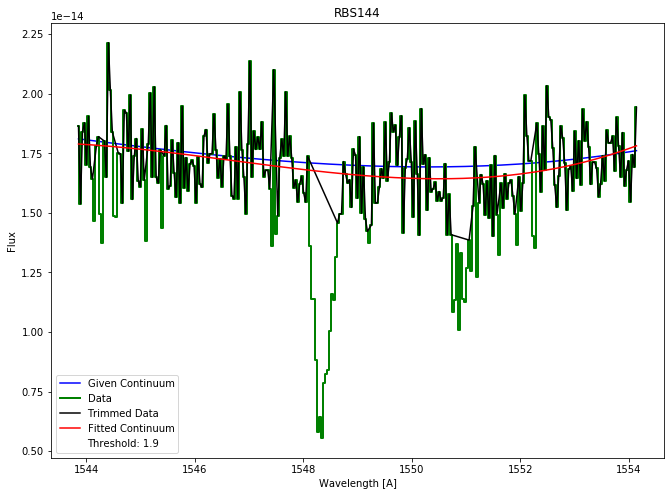

In [4]:
new_ctn = find_continuum(name)

fn = fl / new_ctn
fne = fe / new_ctn

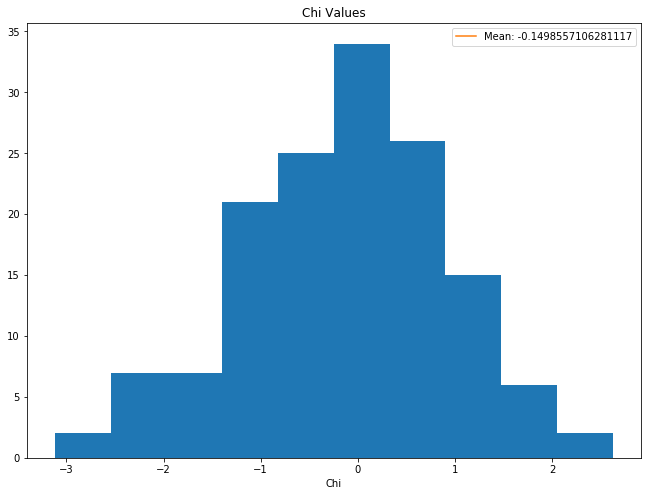

In [5]:
chi, chi_mean = find_chi(wl, fl, fe, new_ctn)
plot_chi_histogram(chi, chi_mean)

#flag_1553 = np.invert((wl > 1552.7) & (wl < 1553.5))

#new_chi, new_chi_mean = find_chi(wl[flag_1553], fl[flag_1553], fe[flag_1553], new_ctn[flag_1553])
#plot_chi_histogram(new_chi, new_chi_mean)

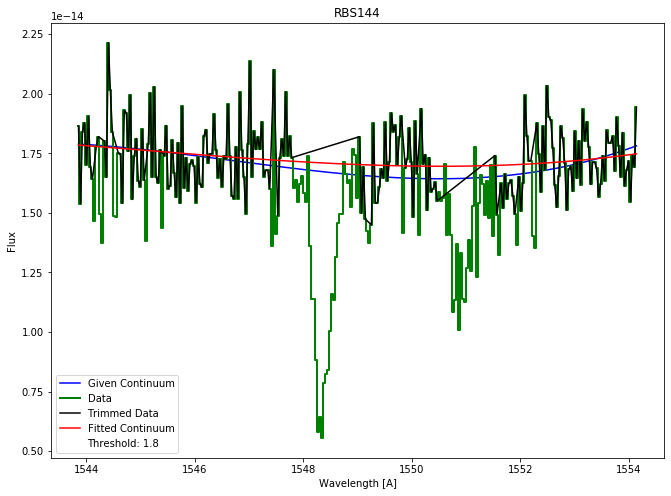

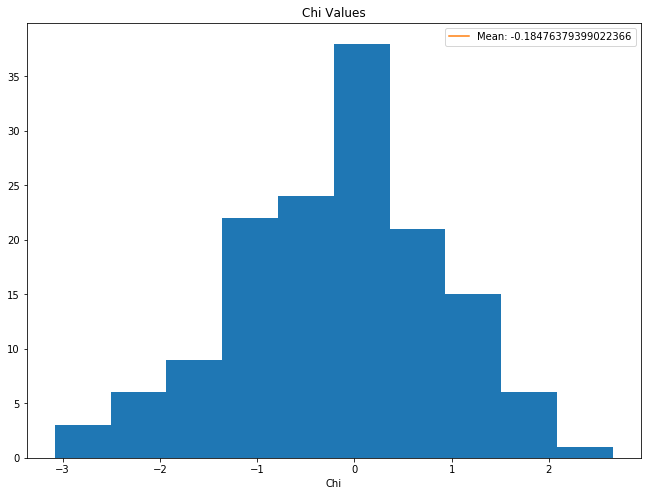

In [6]:
def find_new_continuum(name):
    threshold = np.arange(1.2, 2, .1)
    t = threshold[0]
    wl_out, fl_out, fe_out, ctn_func = continuum(wl_ctn, fl_ctn, fe_ctn, t)
    chi, chi_mean = find_chi(wl_ctn, fl_ctn, fe_ctn, ctn_func(wl_ctn))
    for th in threshold:
        wl_1, fl_1, fe_1, ctn_function = continuum(wl_ctn, fl_ctn, fe_ctn, th)
        chi_1, chi_mean_1 = find_chi(wl_ctn, fl_ctn, fe_ctn, ctn_function(wl_ctn))
        if (np.abs(chi_mean_1) < np.abs(chi_mean)):
            wl_out, fl_out, fe_out, ctn_func = wl_1, fl_1, fe_1, ctn_function
            t = th
            chi, chi_mean = chi_1, chi_mean_1
    plot_continuum(wl, wl_out, fl, fl_out, ctn, ctn_func, name, round(t,1))
    #plot_chi_histogram(chi, chi_mean)
    return ctn_func(wl)

ctn_flag = np.invert((wl > 1547.8) & (wl < 1549)) & np.invert((wl > 1550.5) & (wl < 1551.5))

wl_ctn = wl[ctn_flag]
fl_ctn = fl[ctn_flag]
fe_ctn = fe[ctn_flag]

ctn = new_ctn 

new_ctn2 = find_new_continuum(name)

chi2, chi_mean2 = find_chi(wl, fl, fe, new_ctn2)
plot_chi_histogram(chi2, chi_mean2)

fn = fl / new_ctn2
fne = fe / new_ctn2


In [7]:
x0 = [13.5, 20.3, Wave2V(1548.2, wl1)]
p0, cov, a, b, c = leastsq(fitting, x0, full_output=1)

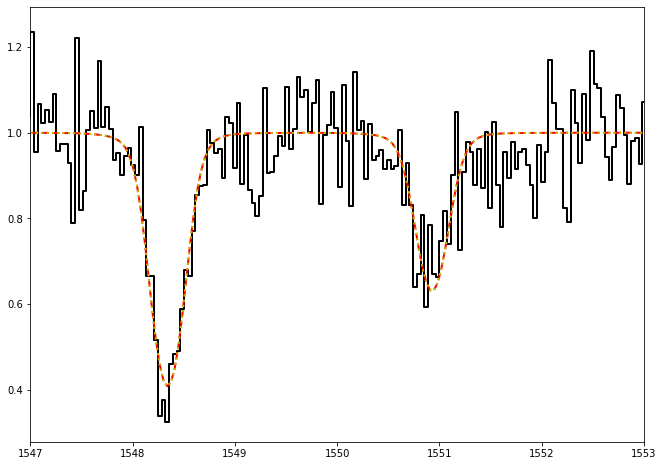

[13.96120007 36.5976753  28.47214647]


In [8]:
plot_model(p0)
print(p0)

(-200, 300)

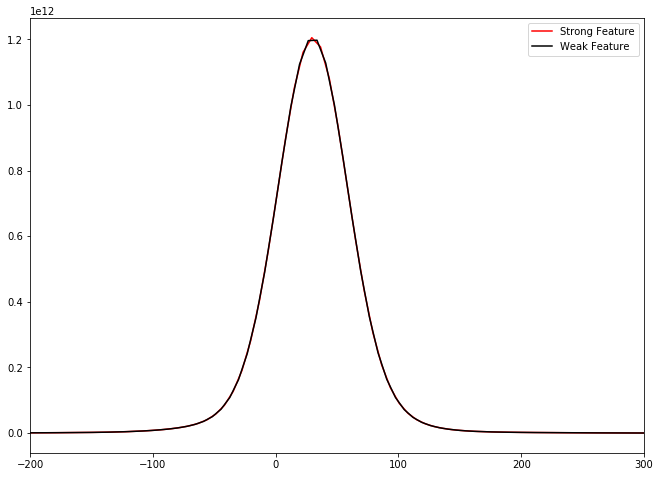

In [9]:
N1, N2 = make_features(p0)
plt.plot(Wave2V(wl, wl1), N1, '-r', label='Strong Feature')
plt.plot(Wave2V(wl, wl2), N2, '-k', label='Weak Feature')
plt.legend()
plt.xlim(-200,300)

In [10]:
Ne1 = nfle2Nev(fn, fne, f1, wl1)
Ne2 = nfle2Nev(fn, fne, f2, wl2)
N1r, N2r = add_residual(p0, N1, N2)

(-200, 300)

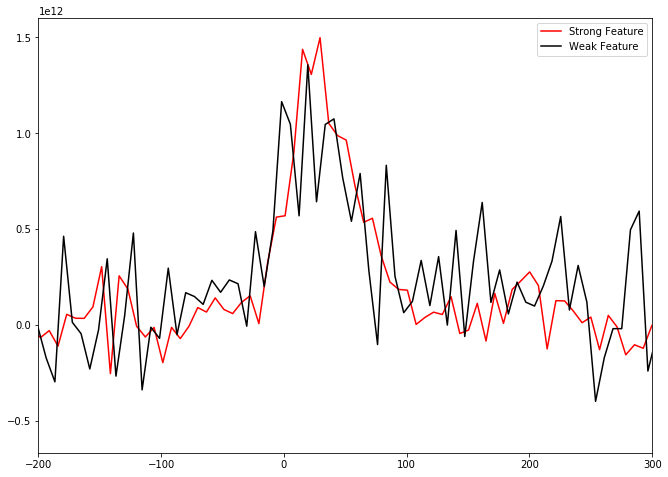

In [11]:
plt.plot(Wave2V(wl, wl1), N1r, '-r', label='Strong Feature')
plt.plot(Wave2V(wl, wl2), N2r, '-k', label='Weak Feature')
plt.legend()
plt.xlim(-200,300)

In [12]:
feature_flag2 = np.invert((Wave2V(wl, wl2) > -5) & (Wave2V(wl, wl2) < 15)) # to get rid of this feature 

In [13]:
v1 =  Wave2V(wl, wl1)
Nv1 = N1r
Nve1 = Ne1

v2 =  Wave2V(wl, wl2)[feature_flag2]
Nv2 = N2r[feature_flag2]
Nve2 = Ne2[feature_flag2]

In [14]:
Nv = np.append(Nv1, Nv2)
Nve = np.append(Nve1, Nve2)
v = np.append(v1, v2)

idx = np.argsort(v)
v_sorted = v[idx]
Nv_sorted = Nv[idx]
Nve_sorted = Nve[idx]

New_v = np.linspace(-400, 400, 101) # dv ~ 8
indices = np.searchsorted(v_sorted, New_v)
v_bins = np.split(v_sorted, indices)

(-200, 300)

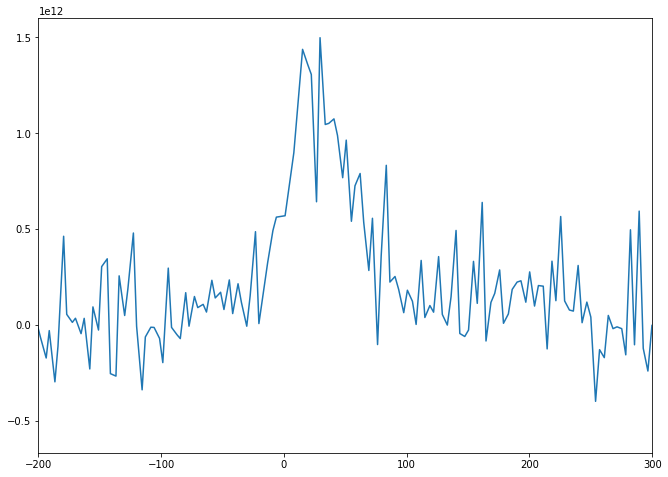

In [15]:
plt.plot(v_sorted, Nv_sorted)
plt.xlim(-200,300)

In [16]:
v_final, Nv_final, Nve_final =  final_data(v_bins, Nv_sorted, Nve_sorted)

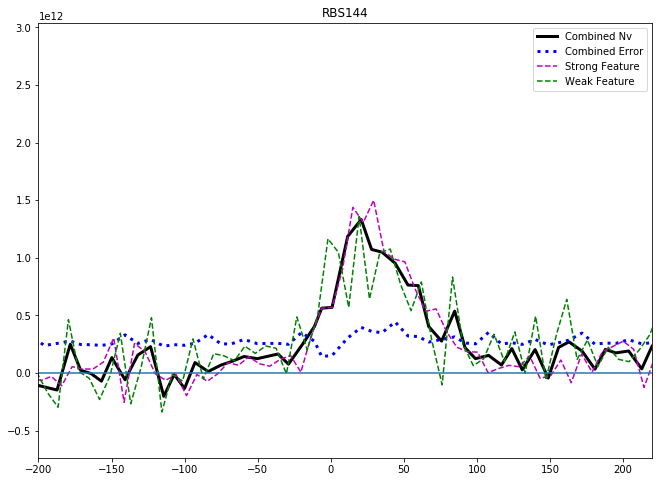

In [17]:
plt.plot(v_final, Nv_final,'k-', lw=3, label='Combined Nv')
plt.plot(v_final, Nve_final, 'b:', lw=3, label='Combined Error')
plt.plot(Wave2V(wl, wl1), N1r, '--m', label='Strong Feature')
plt.plot(Wave2V(wl, wl2), N2r, '--g', label='Weak Feature')
plt.xlim(-200,220)
plt.title(name)
plt.axhline(0)
plt.legend()